# Deep Learning Assignment-4-2

## Mounting the drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Importing libraries

In [0]:
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
%pwd
%cd gdrive/My Drive/Colab Notebooks/dl_assignment_4
%pwd

/content/gdrive/My Drive/Colab Notebooks/dl_assignment_4


'/content/gdrive/My Drive/Colab Notebooks/dl_assignment_4'

In [8]:
%ls -ltr

total 71619
-rw------- 1 root root  3223971 Nov 27 03:38 hw4_te7.pkl
-rw------- 1 root root 18104961 Nov 27 03:38 hw4_tes.pkl
-rw------- 1 root root 19647203 Nov 27 03:39 hw4_tr7.pkl
-rw------- 1 root root 32360162 Nov 27 03:40 hw4_trs.pkl


## Reading the data from pickle files

In [0]:
with open('hw4_tr7.pkl', 'rb') as f:
  train_d = pickle.load(f)

In [0]:
with open('hw4_te7.pkl', 'rb') as f:
  test_d = pickle.load(f)

## Function for encoder with 2 conv layers,2 pool layers,1 flat layer and 2 dense layers

In [0]:
def var_encoder(input):

  input_layer = tf.reshape(input, [-1, 28, 28, 1])
  
  hidden1 = tf.layers.conv2d(inputs=input_layer,filters=16,kernel_size=[4,4],padding="same",activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer())
  pool1 = tf.layers.max_pooling2d(inputs=hidden1, pool_size=[4,4], strides=4)
  hidden2 = tf.layers.conv2d(inputs=pool1,filters=32,kernel_size=[2,2],padding="same",activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer())
  pool2 = tf.layers.max_pooling2d(inputs=hidden2, pool_size=[4,4], strides=4)  
  flat_layer = tf.layers.flatten(pool2)
  logits = tf.layers.dense(inputs=flat_layer, units=784, activation=tf.nn.relu)
  output = tf.layers.dense(inputs=logits , units = 6)
  mean = output[: , :3] 
  log_sigma_sq = output[: , 3:]
  return mean , log_sigma_sq

## Decoder function 2 conv, 2 pool and 1 dense layer

In [0]:
def var_decoder(input):
  logits = tf.layers.dense(inputs=input, units=112 * 112, activation=tf.nn.relu)
  logit_reshape =  tf.reshape(logits,[-1,112,112,1])  
  hidden2 = tf.layers.conv2d(inputs=logit_reshape,filters=32,kernel_size=[4,4],padding="same",activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer())
  pool2 = tf.layers.max_pooling2d(inputs=hidden2, pool_size=[2,2], strides=2) 
  hidden1 = tf.layers.conv2d(inputs=pool2,filters=1,kernel_size=[2,2],padding="same",activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer())
  pool1 = tf.layers.max_pooling2d(inputs=hidden1, pool_size=[2,2], strides=2)
  return pool1

In [0]:
X = tf.placeholder(tf.float32, [None, 28 , 28])
y = tf.placeholder(tf.float32, [None, 28 , 28])

## Learing rate,number of epochs,batch size

In [0]:
n = train_d.shape[0]
learning_rate = 0.001
n_epochs = 150
batch_size = 25

In [15]:
mean, log_sigma_sq = var_encoder(X)
epsilon = tf.random_normal(shape=tf.shape(mean) , dtype=tf.float32)
sigma = tf.exp(0.5 * log_sigma_sq)
latent_vector = mean + epsilon * sigma

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [0]:
logits = var_decoder(latent_vector)
logits = tf.reshape(logits,[-1,28,28])

regen_img = tf.sigmoid(logits)
regen_img = tf.reshape(regen_img,[-1,28,28])

In [17]:
cross_entropy_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_sq) + tf.square(mean) - 1 -log_sigma_sq)
loss = cross_entropy_loss + latent_loss
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Training the model 

In [19]:
loss_list = []
for epoch in range(n_epochs+1):
    loss_calc = 0
    total_loss = 0
    for i in range(0 , n, batch_size):
      batch_x = train_d[i:i+batch_size , : , :]
      batch_y = train_d[i:i+batch_size , : , :]
      feed_dict = {X: batch_x, y: batch_y}
      train_step.run(feed_dict=feed_dict)
      loss_calc += loss.eval(feed_dict=feed_dict)
      
    if epoch%5 == 0:
        loss_list.append((loss_calc))
        print("Epoch %d, loss %g"%(epoch, (loss_calc)))

Epoch 0, loss 1.55327e+06
Epoch 5, loss 908332
Epoch 10, loss 847943
Epoch 15, loss 825527
Epoch 20, loss 813658
Epoch 25, loss 804763
Epoch 30, loss 797870
Epoch 35, loss 791398
Epoch 40, loss 785224
Epoch 45, loss 780584
Epoch 50, loss 774806
Epoch 55, loss 769792
Epoch 60, loss 765717
Epoch 65, loss 760793
Epoch 70, loss 757350
Epoch 75, loss 754301
Epoch 80, loss 752394
Epoch 85, loss 749305
Epoch 90, loss 746638
Epoch 95, loss 744706
Epoch 100, loss 743417
Epoch 105, loss 741351
Epoch 110, loss 740253
Epoch 115, loss 738647
Epoch 120, loss 737475
Epoch 125, loss 736411
Epoch 130, loss 735730
Epoch 135, loss 734600
Epoch 140, loss 734046
Epoch 145, loss 732747
Epoch 150, loss 732692


## Function for generating random code vectors

In [0]:
def gen_code_vector(K , size):
  random_s = np.random.normal(size=[1,K])

  random_samps = np.repeat(random_s, size ,axis=0)
  
  return random_samps
  
def change_col(x , col_num):
  x_copy = x.copy()
  
  n_rows = x.shape[0]
  random_col = np.random.normal(size = [n_rows , 1])
  
  x_copy[: , col_num] = random_col[: , 0]
  
  return x_copy

In [0]:
first_col_change = gen_code_vector(3 , 300)
first_col_change = change_col(first_col_change , 0)

second_col_change = gen_code_vector(3 , 300)
second_col_change = change_col(second_col_change , 1)

third_col_change = gen_code_vector(3 , 300)
third_col_change = change_col(third_col_change , 2)

## Function to generate plots

In [0]:
def plots(data, plot_heading , image_index , row , col):
    
    fig , ax = plt.subplots(row , col, sharex=True, sharey=True, figsize=(row,col))
    
    for i in range(row):
        for j in range(col):
            idx = image_index[i * row + j]
            digits = data[idx]
            
            ax[i][j].imshow(digits, aspect='auto')
            ax[i][j].axis('off')
    
    fig.subplots_adjust(hspace=.1)
    fig.suptitle(plot_heading)
    plt.show()

In [0]:
row = 5
col = 5
max_images = 300
image_indices = random.sample(range(max_images) , k=row * col)
image_indices.sort()

In [0]:
feed_dict = {X : train_d[0:300]}
regen_train = regen_img.eval(feed_dict=feed_dict)

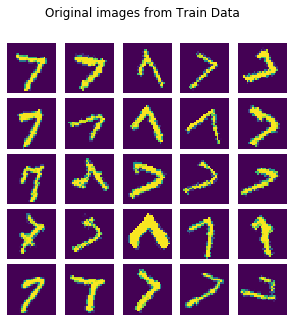

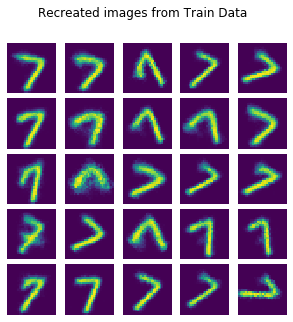

In [28]:
plots(train_d, 'Original images from Train Data' , image_indices , 5 , 5)
plots(regen_train , 'Recreated images from Train Data' , image_indices , 5 , 5)

In [0]:
regen_latent_1 = regen_img.eval(feed_dict={latent_vector: first_col_change})
regen_latent_2 = regen_img.eval(feed_dict={latent_vector: second_col_change})
regen_latent_3 = regen_img.eval(feed_dict={latent_vector: third_col_change})

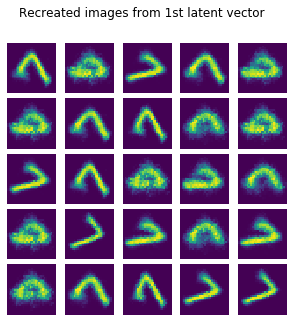

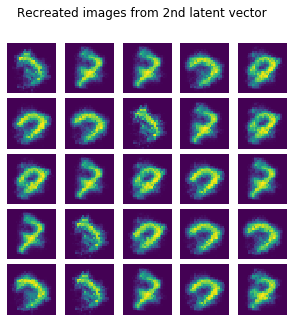

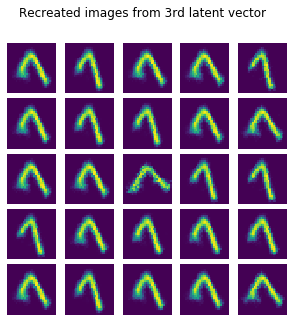

In [32]:
plots(regen_latent_1 , 'Recreated images from 1st latent vector' , image_indices , 5 , 5)
plots(regen_latent_2 , 'Recreated images from 2nd latent vector' , image_indices , 5 , 5)
plots(regen_latent_3 , 'Recreated images from 3rd latent vector' , image_indices , 5 , 5)

In [0]:
regen_test = regen_img.eval(feed_dict={X : test_d})

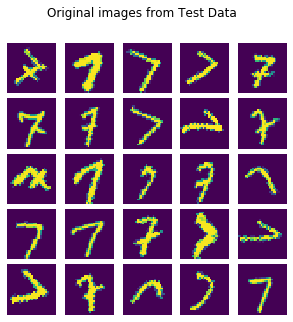

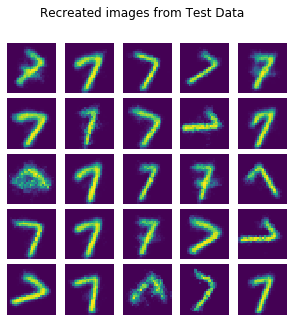

In [35]:
plots(test_d , 'Original images from Test Data' , image_indices , 5 , 5)
plots(regen_test , 'Recreated images from Test Data' , image_indices , 5 , 5)